Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Transient Absorption Spectroscopy Experiment {-}

## Preliminary Setup {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [44]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression


# The following needs to be the path of the folder with all your datafile in .csv format
base_path = '/Users/School/PycharmProjects/PChemLab/TA_Data'

In [45]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a Transient Absorption Spectroscopy .csv file. 
    The format of the file should have one row of header, semicolon as separator, and colon as decimal separator

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with multiple columns: Laser Delay (in nanoseconds)
        and one column for each TA run in units of mOD
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],sep=';',decimal='.') 
    file_dict['data'] = data
    return

def plot_file_dict(file_dict, yaxis = 'all'):
    """ 
    Given a file dictionary, plot one of the transient absorption curves (or the average)
    versus the laser delay
    """
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
    if yaxis == 'all':
        for column in file_dict['data'].columns:
            if column == 'Laser Delay [ns]' : continue
            plt.plot(file_dict['data']['Laser Delay [ns]'],file_dict['data'][column],label=column)
    else : 
        if yaxis in file_dict['data'].columns:
            plt.plot(file_dict['data']['Laser Delay [ns]'],file_dict['data'][yaxis],label=yaxis)
        else:
            print('ERROR: specified yaxis is not in the read data')
    plt.ylabel('Transient Absorption [mOD]')
    plt.xlabel('Laser Delay [ns]')
    plt.legend()
    plt.show()

def plot_file_list(file_list,yaxis = 'TA1 [mOD]'):
    """
    Given a list of dictionary files, plot one of the transient absorption curves (or the average)
    versus the laser delay for each of the files
    """
    #
    fig, ax = plt.subplots()
    #
    for file_dict in file_list : 
        (file_dict)
        plt.plot(file_dict['data']['Laser Delay [ns]'],file_dict['data'][yaxis],label=file_dict['label'])
    plt.ylabel('Transient Absorption [mOD]')
    plt.xlabel('Laser Delay [ns]')
    plt.legend()
    plt.show()

In [46]:
# @title Utilities to analyze the data { display-mode: "form" }
def exponential(t, a, tau, o):
    """ 
    Function that returns an exponentially decaying function plus offset
    f(t) = o + a*e^(-t/tau)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    tau: lifetime (units of time)
    o: offset (units of absorbance or concentration)
    """
    if tau < 1.e-10 : 
        print('ERROR: choose a value of tau greater than zero')
        return 0.
    return a * np.exp(-t/tau) + o

def fit_ta_data(file_dict, yaxis = 'TA1 [mOD]', verbose = False, semilog = False):
    """ 
    Perform the fit of transient absorption decay curves using an exponential 
    functions plus offset. 

    Input parameters: 
    file_dict: a dictionary with information on the file with the data (path and name) and
               adjustable parameters related to the fit:
               time_skip : initial transient regime to remove from the fit
               C0_guess, k_guess, offset_guess: starting guess of fitting parameters
    yaxis : the column of the dataframe to use for the fit
    verbose : if True plot the filtered data and the corresponding fit
    semilog : if True, plot in semilogy scale

    Action: 
           Filter the data by removing the initial time_skip part of the curve
           Fit according to an exponential decay
           Save the optimized values of the parameters and their standard errors in file_dict
           Save the fitted curve in the file_dict['data'] DataFrame
    """   
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
    xaxis = 'Laser Delay [ns]'
        
    file_dict['filtered_data'] = file_dict['data'][file_dict['data']['Laser Delay [ns]']>file_dict['time_skip']].copy()
    x = file_dict['filtered_data'][xaxis]
    y = file_dict['filtered_data'][yaxis]

    funct = exponential
    p0 = (file_dict['DA0_guess'],file_dict['tau_guess'],file_dict['offset_guess'])
    params, cv = scipy.optimize.curve_fit(funct,x,y,p0)

    file_dict['DA0'] = params[0]
    file_dict['DA0_SE'] = np.sqrt(cv[0,0])
    file_dict['tau'] = params[1]
    file_dict['tau_SE'] = np.sqrt(cv[1,1])
    file_dict['offset'] = params[2] 
    file_dict['offset_SE'] = np.sqrt(cv[2,2])

    file_dict['filtered_data']['TA_fitted'] = funct(x,params[0],params[1],params[2])

    if verbose :
        if semilog :
            plt.semilogy(x,y,label=yaxis)
            plt.semilogy(x,funct(x,params[0],params[1],params[2]),label='Fit')
        else :
            plt.plot(x,y,label=yaxis)
            plt.plot(x,funct(x,params[0],params[1],params[2]),label='Fit')
        plt.ylabel('Transient Absorption [mOD]')
        plt.xlabel('Laser Delay [ns]')
        plt.legend()
        plt.show()

The functions below are incomplete and will need to be completed by the student

In [47]:
def calc_average_TA(file_dict):
    """
    Average all the TA runs recorded in a TA .csv file.

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Create a new column in the file_dict['data'] component of the input with the average
        of the TA runs recorded in the file
    """
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
    columns = file_dict['data'].columns.drop('Laser Delay [ns]')
    if 'TAaverage' in file_dict['data'].columns: 
        columns = columns.drop('TAaverage')
    # the variable columns is a list that contains the columns of the dataframe you need to average
    file_dict['data']['TAaverage'] = file_dict['data'][columns].mean(axis=1)
    return

def calc_max_TA(file_dict):
    """
    Given a file dictionary with the average TA, find the maximum value of the transient absorption 
    and the Laser Delay at which this value occurs

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        
    """
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
    if not ('TAaverage' in file_dict['data'].columns): 
        calc_average_TA(file_dict)
    # Find the index of the maximum value in the 'TAaverage' column
    max_index = file_dict['data']['TAaverage'].idxmax()

    # Store the maximum value and corresponding laser delay
    file_dict['TAmax'] = file_dict['data']['TAaverage'].iloc[max_index]
    file_dict['LD_TAmax'] = file_dict['data']['Laser Delay [ns]'].iloc[max_index]
    return

## Visualize the Systems {-}

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [48]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILES or their CAS numbers. Luckily, CIRpy can usually find SMILES for you, if you type the common name correctly or if you know the CAS number. 

These are the CAS numbers for the molecule in your TA experiments:
* ZnTPP (5,10,15,20-Tetraphenyl-21H,23H-porphine zinc): CAS 14074-80-7
* Fullerene C70: CAS 115383-22-7

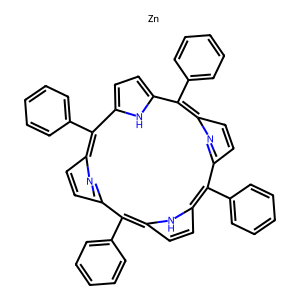

In [49]:
# @title Choose the molecule to draw { display-mode: "form" }
input = '5,10,15,20-Tetraphenyl-21H,23H-porphine zinc' # @param {type:"string"}
input_type = 'name' # @param ["smiles", "name", "cas"] {allow-input: true}
if input_type != 'smiles' :
    smiles=cirpy.resolve( input, 'smiles')
else:
    smiles=input
img = Draw.MolToImage( Chem.MolFromSmiles(smiles), size=(300, 300) )
display(img)

## Loading the Data {-}

We need to load the Google Drive and access an example of a dataset from a kinetics experiment. You can use the same set that I am using by downloading it from Canvas, [here](). Or you can use your own files. I am assuming the file in question will be located in a `Kinetics_Data/` subfolder in your `Colab Notebook/` folder. 

In [50]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format

path = "/Users/School/PycharmProjects/PChemLab/TA_Data/Transient_Absorption/"

In order to streamline the fitting of the data, we will be storing the information that corresponds to each TA file into a Python dictionary (`dict`), together with all the relevant information of that experiment and the parameters that we need for the fit. You can use the same statement in the following, but make sure to change the file name from 'TA_traces.csv' (the one that I am using) to the one you want to use.

In [51]:
file1 = {'path':path, 'name':'BZ02_traces_JGD.csv', 'label':'Run1', '[ZnTPP]': 0.2, '[C70]':0., 'time_skip':0, 'DA0_guess':1., 'tau_guess':1., 'offset_guess':0.}

We can load the data into each dictionary as follows

In [52]:
load_data_to_file_dict(file1)

This will create a new component of the dictionary named 'data', which will contain a DataFrame generated from the DSC file specified in the dictionary. We should always check that the loaded data looks ok, say by checking the number of columns and rows and, maybe, plotting the two columns

In [53]:
file1['data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Laser Delay [ns]  541 non-null    int64  
 1   TA1 [mOD]         541 non-null    float64
 2   TA2 [mOD]         541 non-null    float64
 3   TA3 [mOD]         541 non-null    float64
 4   TA4 [mOD]         541 non-null    float64
 5   TA5 [mOD]         541 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 25.5 KB


<Axes: xlabel='Laser Delay [ns]'>

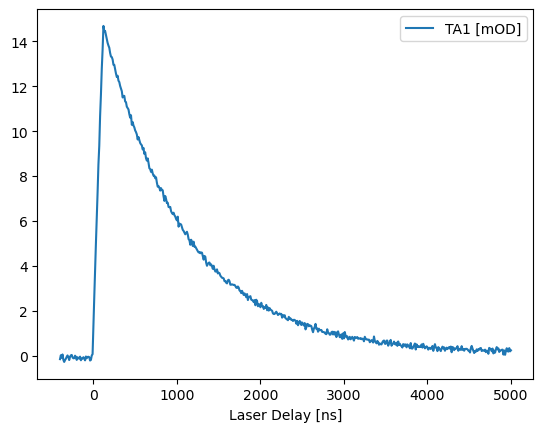

In [54]:
file1['data'].plot('Laser Delay [ns]','TA1 [mOD]')

However, we created a set of tools to load the data and plot them in one step. For a single dictionary you can use

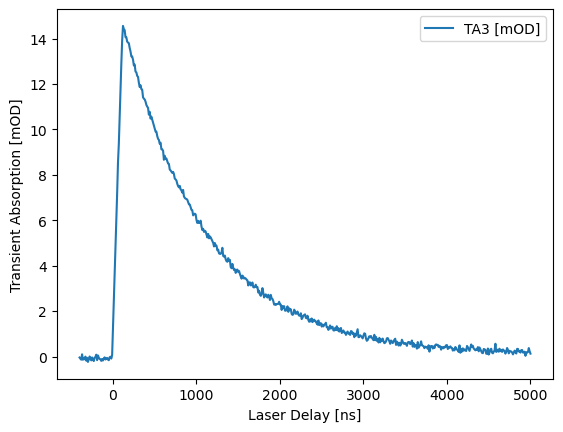

In [55]:
plot_file_dict(file1,'TA3 [mOD]')

But if you want to all the columns in your data in the same plot, you can specify 'all' as an option

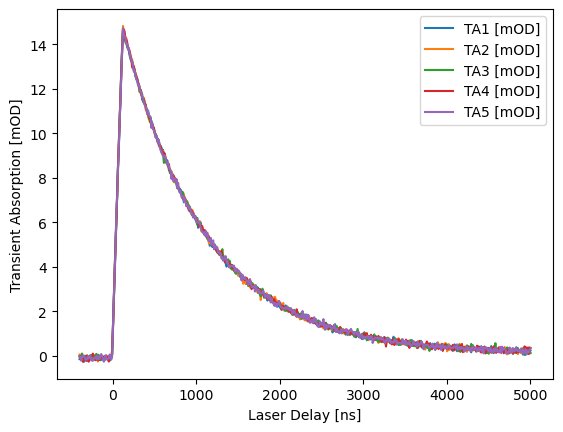

In [56]:
plot_file_dict(file1,'all')

The first task of the worksheet will ask you to compute the average of the different TA runs that are recorded in the file. This task is implemented in a function at the beginning of this notebook, but you will need to figure out how to do the average of multiple columns of a dataframe. You can try to implement the calculation in the following box and see if you can compute the average between the first two columns of the data

In [57]:
file1['data'][['TA1 [mOD]','TA2 [mOD]']]


,TA1 [mOD],TA2 [mOD]
0,-0.156040,0.052836
1,0.020170,-0.073852
2,-0.095081,-0.105654
3,0.054264,-0.112342
4,-0.186523,-0.068750
...,...,...
536,0.199075,0.151738
537,0.180065,0.176861
538,0.335933,0.168173
539,0.191369,0.163053


Once you have figured out a command that works on the case above, try to implement it in the function `calc_average_TA()` that is implemented at the beginning of this notebook.

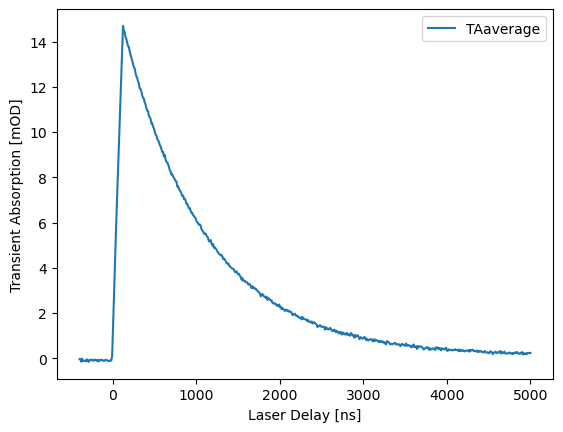

In [58]:
calc_average_TA(file1)
plot_file_dict(file1,'TAaverage')

## Adjust the Analysis Parameters {-}

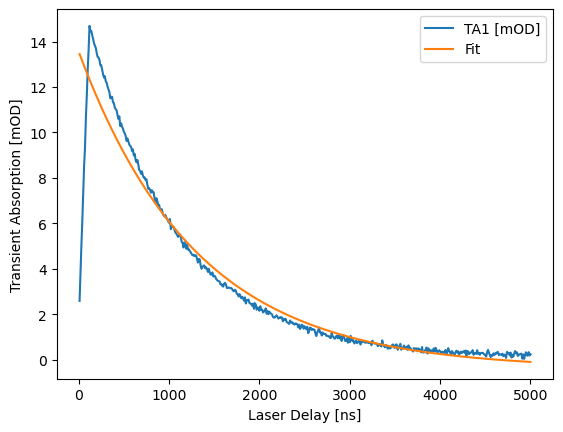

In [59]:
# @title Adjust the parameters for the non-linear fit { display-mode: "form" }
yaxis = 'TA1 [mOD]' # @param ['TAaverage','TA1 [mOD]','TA2 [mOD]']
time_skip = 0 # @param {type:"number"}
DA0_guess = 100. # @param {type:"number"}
tau_guess = 1000 # @param {type:"number"}
offset_guess = 0. # @param {type:"number"}
semilog = False # @param {type:"boolean"}
file1['time_skip'] = time_skip
file1['DA0_guess'] = DA0_guess
file1['tau_guess'] = tau_guess
file1['offset_guess'] = offset_guess
fit_ta_data(file1, yaxis=yaxis, verbose=True, semilog=semilog)

In [60]:
print(f"The transient lifetime is {file1['tau']:6.2f} ns and its associated standard error is {file1['tau_SE']:4.2f} ns")

The transient lifetime is 1302.54 ns and its associated standard error is 45.75 ns


## Check Each of Your Experiments

Repeat this analysis for each one of your files. Make sure to take note of the parameters that affect your analysis the most, you will need them in your worksheet. 

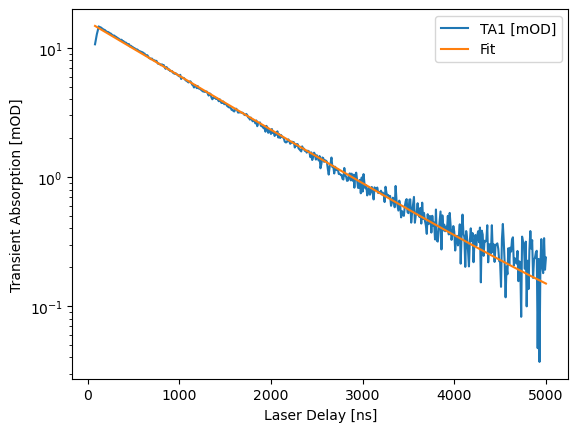

In [68]:
# @title Adjust the parameters for each of your files { display-mode: "form" }
filename = 'BZ02_traces_JGD.csv' # @param {type:"string"}
yaxis = 'TA1 [mOD]' # @param ['TAaverage','TA1 [mOD]','TA2 [mOD]']
time_skip = 75 # @param {type:"number"}
DA0_guess = 15. # @param {type:"number"}
tau_guess = 500 # @param {type:"number"}
offset_guess = 0. # @param {type:"number"}
semilog = True # @param {type:"boolean"}
newfile = {'path':path, 'name':filename, 'label':'Run1', '[ZnTPP]': 0.2, '[C70]':0., 'time_skip':time_skip, 'DA0_guess':DA0_guess, 'tau_guess':tau_guess, 'offset_guess':offset_guess} 
load_data_to_file_dict(newfile)
calc_average_TA(newfile)
fit_ta_data(newfile,yaxis=yaxis,verbose=True, semilog=semilog)

In [62]:
calc_max_TA(file1)
print(f"The maximum TA value is {file1['TAmax']:6.2f} mOD at a laser delay of {file1['LD_TAmax']:6.2f} ns.")

The maximum TA value is  14.70 mOD at a laser delay of 120.00 ns.
